# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [1]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

/bin/bash: kaggle: command not found
unzip:  cannot find or open traffic-dataset.zip, traffic-dataset.zip.zip or traffic-dataset.zip.ZIP.


In [179]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from keras.optimizers import SGD
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv('Traffic Data.csv')
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00
...,...,...,...,...,...,...,...,...
19995,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,2018-06-06 21:00:00
19996,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,2017-10-25 15:00:00
19997,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,2018-03-28 23:00:00
19998,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds,2018-02-12 15:00:00


In [5]:
df.head(10)

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00
5,4257.0,293.66,0.0,0.0,75,Rain,moderate rain,2018-06-09 12:00:00
6,3707.0,292.75,0.0,0.0,40,Rain,proximity shower rain,2018-07-26 19:00:00
7,5646.0,299.55,0.0,0.0,1,Thunderstorm,proximity thunderstorm,2018-08-03 15:00:00
8,2642.0,275.29,0.0,0.0,90,Fog,fog,2018-01-10 20:00:00
9,801.0,296.43,0.0,0.0,1,Clear,sky is clear,2018-08-09 00:00:00


In [9]:
df['date_time'] = pd.to_datetime(df['date_time'])
df.set_index('date_time', inplace=True)

In [38]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,prev_traffic_volume,traffic_volume_diff,day_of_week,month,day_of_year,traffic_volume_lag_1,traffic_volume_ma_3
date_time,,,,,,,,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist,NaN,NaN,Sunday,8,323,NaN,NaN
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,NaN,39.0,Thursday,9,323,1209.0,NaN
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,NaN,3354.0,Friday,8,323,1248.0,2353.000000
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,NaN,-1764.0,Thursday,11,323,4602.0,2896.000000
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,NaN,2956.0,Thursday,11,323,2838.0,4411.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-06 21:00:00,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,5954.0,-3878.0,Wednesday,6,273,6601.0,3204.000000
2017-10-25 15:00:00,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,3117.0,3172.0,Wednesday,10,273,2723.0,5073.000000
2018-03-28 23:00:00,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,4578.0,-4763.0,Wednesday,3,273,5895.0,3250.000000


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

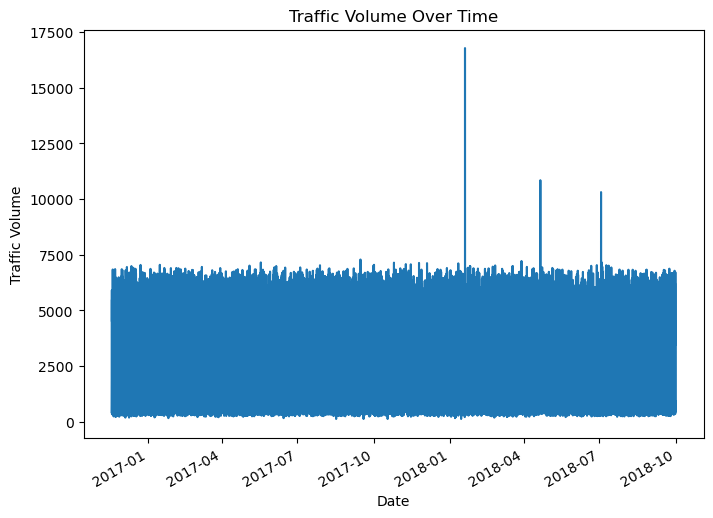

In [83]:
# Plot the time series
plt.figure(figsize=(8, 6))
df['traffic_volume'].plot()
plt.title('Traffic Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.show()

       traffic_volume          temp       rain_1h  snow_1h    clouds_all  \
count     20000.00000  20000.000000  20000.000000  20000.0  20000.000000   
mean       3277.60735    281.162680      0.048395      0.0     49.384600   
std        1977.09155     12.661288      0.398007      0.0     39.647341   
min         113.00000    243.390000      0.000000      0.0      0.000000   
25%        1228.00000    271.950000      0.000000      0.0      1.000000   
50%        3427.00000    281.825000      0.000000      0.0     75.000000   
75%        4927.00000    291.840000      0.000000      0.0     90.000000   
max       16781.00000    310.070000     10.600000      0.0     92.000000   

       prev_traffic_volume  traffic_volume_diff         month   day_of_year  \
count         20000.000000         20000.000000  20000.000000  20000.000000   
mean           3278.239287            -0.195910      6.288000    176.093900   
std            1976.270429           771.767226      3.423163    104.861801   

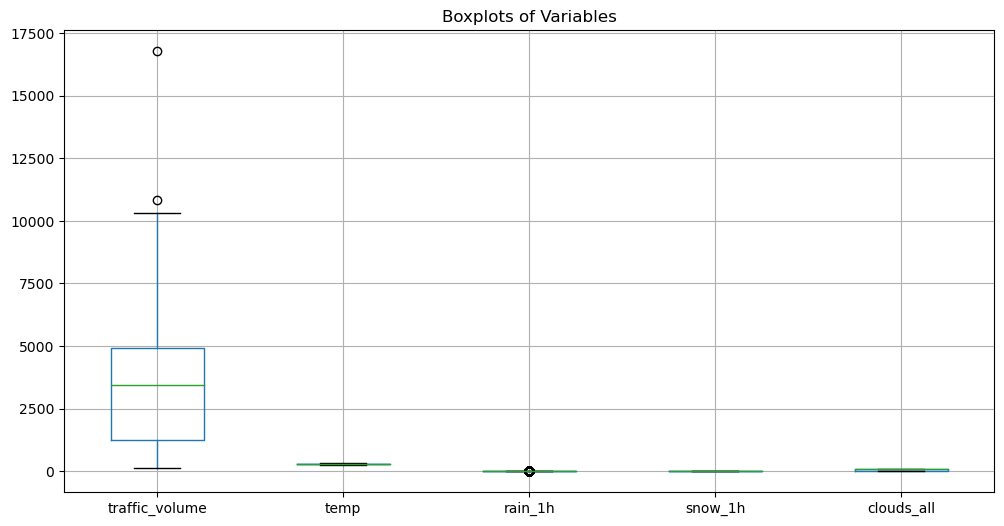

In [81]:
print(df.describe())

#identify outliers
plt.figure(figsize=(12, 6))
df.boxplot(column=['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all'])
plt.title('Boxplots of Variables')
plt.show()

<Figure size 1200x800 with 0 Axes>

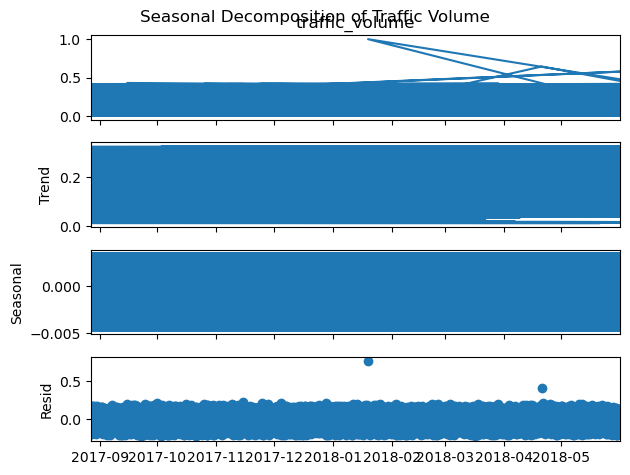

In [188]:
# Seasonal Decomposition
result = seasonal_decompose(df['traffic_volume'], model='additive', period=24)

plt.figure(figsize=(12, 8))
result.plot()
plt.suptitle('Seasonal Decomposition of Traffic Volume')
plt.show()

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [20]:
#handle missing values
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

In [25]:
print(df.isna().sum())
data = df.fillna(0)

traffic_volume         0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
dtype: int64


In [48]:
# Create features
data['traffic_volume_lag_1'] = data['traffic_volume'].shift(1)
data['traffic_volume_ma_3'] = data['traffic_volume'].rolling(window=3).mean()

In [49]:
# Sort the dates
data = data.sort_index()

In [50]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,prev_traffic_volume,traffic_volume_diff,day_of_week,month,day_of_year,traffic_volume_lag_1,traffic_volume_ma_3
date_time,,,,,,,,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist,NaN,NaN,Sunday,8,323,NaN,NaN
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,NaN,39.0,Thursday,9,323,1209.0,NaN
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,NaN,3354.0,Friday,8,323,1248.0,2353.000000
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,NaN,-1764.0,Thursday,11,323,4602.0,2896.000000
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,NaN,2956.0,Thursday,11,323,2838.0,4411.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-06 21:00:00,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,5954.0,-3878.0,Wednesday,6,273,6601.0,3204.000000
2017-10-25 15:00:00,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,3117.0,3172.0,Wednesday,10,273,2723.0,5073.000000
2018-03-28 23:00:00,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,4578.0,-4763.0,Wednesday,3,273,5895.0,3250.000000


In [76]:
imp = SimpleImputer(strategy='mean')
num_cols = ['traffic_volume', 
            'temp', 
            'rain_1h',
            'snow_1h',
            'clouds_all', 
            'prev_traffic_volume', 
            'traffic_volume_diff', 
            'traffic_volume_lag_1', 
            'traffic_volume_ma_3']
df[num_cols] = imp.fit_transform(data[num_cols])

In [77]:
# Fill missing values
df['weather_main'] = df['weather_main'].fillna('Unknown')
df['weather_description'] = df['weather_description'].fillna('Unknown')
df['day_of_week'] = df['day_of_week'].fillna('Unknown')
df['month'] = df['month'].fillna('Unknown')
df['day_of_year'] = df['day_of_year'].fillna(-1)

In [78]:
df.isnull().sum()

traffic_volume          0
temp                    0
rain_1h                 0
snow_1h                 0
clouds_all              0
weather_main            0
weather_description     0
prev_traffic_volume     0
traffic_volume_diff     0
day_of_week             0
month                   0
day_of_year             0
traffic_volume_lag_1    0
traffic_volume_ma_3     0
dtype: int64

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20000 entries, 2017-08-27 01:00:00 to 2018-05-31 18:00:00
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   traffic_volume        20000 non-null  float64
 1   temp                  20000 non-null  float64
 2   rain_1h               20000 non-null  float64
 3   snow_1h               20000 non-null  float64
 4   clouds_all            20000 non-null  int64  
 5   weather_main          20000 non-null  object 
 6   weather_description   20000 non-null  object 
 7   prev_traffic_volume   19976 non-null  float64
 8   traffic_volume_diff   19999 non-null  float64
 9   day_of_week           20000 non-null  object 
 10  month                 20000 non-null  int32  
 11  day_of_year           20000 non-null  int32  
 12  traffic_volume_lag_1  19999 non-null  float64
 13  traffic_volume_ma_3   19998 non-null  float64
dtypes: float64(8), int32(2), int64(1), 

In [79]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,prev_traffic_volume,traffic_volume_diff,day_of_week,month,day_of_year,traffic_volume_lag_1,traffic_volume_ma_3
date_time,,,,,,,,,,,,,,
2017-08-27 01:00:00,4872.0,274.08,0.0,0.0,90.0,Mist,mist,3278.239287,-0.19591,Sunday,8,323,3277.723536,3277.635547
2018-09-06 23:00:00,4872.0,274.08,0.0,0.0,90.0,Clear,sky is clear,3278.239287,0.00000,Thursday,9,323,4872.000000,3277.635547
2017-08-25 18:00:00,4872.0,274.08,0.0,0.0,90.0,Clouds,broken clouds,3278.239287,0.00000,Friday,8,323,4872.000000,4872.000000
2017-11-09 22:00:00,5074.0,273.84,0.0,0.0,90.0,Clear,sky is clear,3278.239287,202.00000,Thursday,11,323,4872.000000,4939.333333
2017-11-09 15:00:00,5074.0,273.84,0.0,0.0,90.0,Clear,sky is clear,3278.239287,0.00000,Thursday,11,323,5074.000000,5006.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-06 21:00:00,3543.0,283.45,0.0,0.0,75.0,Clouds,scattered clouds,2950.000000,-404.00000,Wednesday,6,273,3947.000000,3874.000000
2017-10-25 15:00:00,2781.0,282.76,0.0,0.0,90.0,Clouds,scattered clouds,2607.000000,-762.00000,Wednesday,10,273,3543.000000,3423.666667
2018-03-28 23:00:00,2159.0,282.73,0.0,0.0,90.0,Clear,sky is clear,3856.000000,-622.00000,Wednesday,3,273,2781.000000,2827.666667


## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [55]:
# Shift method 
df['prev_traffic_volume'] = df['traffic_volume'].shift(24)

# Calculate the difference 
df['traffic_volume_diff'] = df['traffic_volume'].diff()


In [56]:
# Feature engineering
df['prev_traffic_volume'] = df['traffic_volume'].shift(24)
df['traffic_volume_diff'] = df['traffic_volume'].diff()
df['day_of_week'] = df.index.day_name()
df['month'] = df.index.month
df['day_of_year'] = data.index.day_of_year

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [105]:
# Split the data into training and testing sets
split_ratio = 0.8


split_index = int(len(df) * split_ratio)


train = df.iloc[:split_index]
test = df.iloc[split_index:]

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [138]:
features = ['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'prev_traffic_volume', 'traffic_volume_diff']
target = 'traffic_volume'
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

df[features] = scaler_X.fit_transform(df[features])
df[[target]] = scaler_y.fit_transform(df[[target]])

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [107]:
#LSTM
#ARIMA

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [122]:
#LSTM
timesteps = 24  

def create_sequences(df, features, target, timesteps):
    X, y = [], []
    for i in range(timesteps, len(df)):
        X.append(df[features].iloc[i-timesteps:i].values)
        y.append(df[target].iloc[i])
    return np.array(X), np.array(y)

X, y = create_sequences(df, features, target, timesteps)

y = y.reshape(-1, 1)

In [126]:
X_train = train[features].values.reshape(-1, 1, len(features))
y_train = train[target].values

X_test = test[features].values.reshape(-1, 1, len(features))
y_test = test[target].values

In [152]:
# Building the LSTM Model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

/Users/mariyayousef/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [153]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [154]:
history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - loss: 0.0120 - val_loss: 0.0044
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - loss: 0.0016 - val_loss: 9.8437e-04
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - loss: 0.0015 - val_loss: 9.2506e-04
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - loss: 0.0014 - val_loss: 8.8587e-04


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [155]:
y_pred = model.predict(X_test)
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler_y.inverse_transform(y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE: 0.09478159745846244


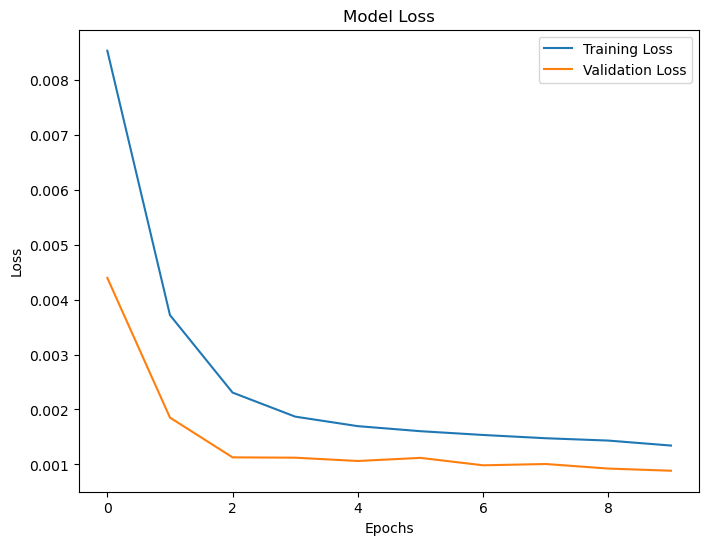

In [231]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

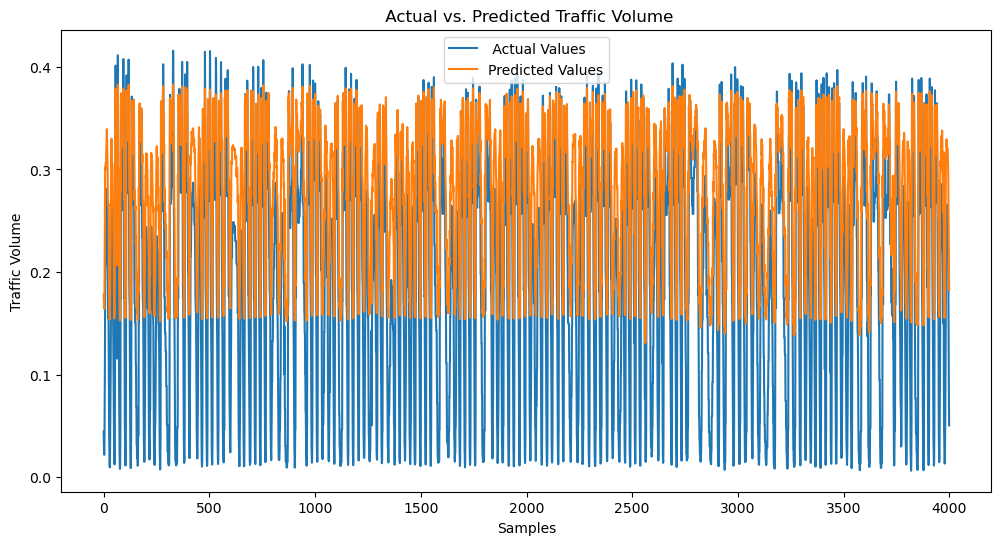

In [164]:
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

plt.figure(figsize=(12, 6))
plt.plot(y_test_flat, label=' Actual Values')
plt.plot(y_pred_flat, label='Predicted Values')
plt.title(' Actual vs. Predicted Traffic Volume')
plt.xlabel('Samples')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [183]:
#RNN
#model = Sequential()

#model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
#model.add(Dropout(0.2))         

#model.add(SimpleRNN(units=50, return_sequences=True))
#model.add(Dropout(0.2))

#model.add(SimpleRNN(units=50))
#model.add(Dropout(0.2))

#model.add(Dense(units=1))
#model.summary()

In [184]:
#model.compile(loss='mean_squared_error',optimizer='adam')  

In [233]:
from statsmodels.tsa.arima.model import ARIMA

model = SARIMAX(train[target],
                order = (0, 1, 1),
                seasonal_order =(1, 1,1, 2))

result = model.fit()
result.summary()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57469D+00    |proj g|=  4.86633D+00


 This problem is unconstrained.



At iterate    5    f= -1.59918D+00    |proj g|=  1.83498D-01

At iterate   10    f= -1.60833D+00    |proj g|=  2.64833D+00

At iterate   15    f= -1.61591D+00    |proj g|=  5.37227D-01

At iterate   20    f= -1.63692D+00    |proj g|=  4.43176D+00

At iterate   25    f= -1.67069D+00    |proj g|=  2.88664D-01

At iterate   30    f= -1.71455D+00    |proj g|=  1.85582D+00

At iterate   35    f= -1.72630D+00    |proj g|=  2.09816D-02

At iterate   40    f= -1.72893D+00    |proj g|=  3.72522D-02

At iterate   45    f= -1.72929D+00    |proj g|=  2.29943D-02

At iterate   50    f= -1.72932D+00    |proj g|=  1.85026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                    traffic_volume   No. Observations:                16000
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 2)   Log Likelihood               27669.113
Date:                           Sun, 25 Aug 2024   AIC                         -55330.226
Time:                                   10:39:08   BIC                         -55299.505
Sample:                                        0   HQIC                        -55320.065
                                         - 16000                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4027      0.003    155.785      0.000       0.398       0.408
ar.S.L2        0.1826      0.005     37.949      0.000       0.173       0.192
ma.S.L2       -0.9999      0.001   -731.861      0.000      -1.003      -0.997
sigma2         0.0018    6.8e-06    270.724      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   3.37   Jarque-Bera (JB):            923020.07
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -0.22
Prob(H) (two-sided):                  0.01   Kurtosis:                        40.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [214]:
start = len(train)
end = len(train) + len(test) - 1

predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")

### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

<Axes: xlabel='date_time'>

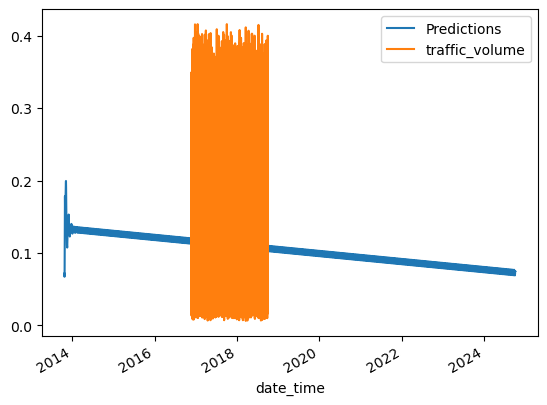

In [236]:
predictions.plot(legend = True)
test['traffic_volume'].plot(legend = True)
#not good plot



In [240]:
#model.predictions.plot(dynamic=False)
#plt.show()

In [222]:
rmse(test["traffic_volume"], predictions)
mean_squared_error(test["traffic_volume"], predictions)

TypeError: 'numpy.float64' object is not callable

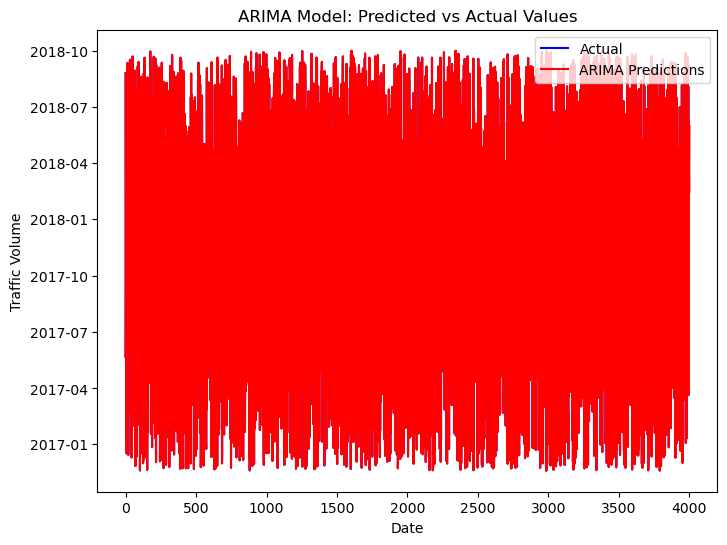

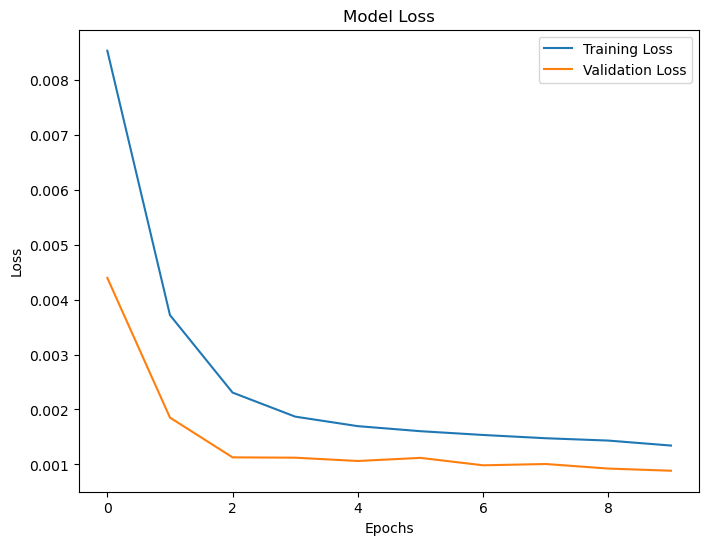

In [225]:
plt.figure(figsize=(8, 6))
plt.plot(test.index,label='Actual', color='blue')
plt.plot(test.index,label='ARIMA Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.title('ARIMA Model: Predicted vs Actual Values')
plt.legend()
plt.show()

#not completed yet
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here: